# Module

In [1]:
import io
import json
import os
import random
import subprocess
import time
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import numpy
import pytesseract
import requests
from IPython.display import clear_output, display
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter
from tqdm import tqdm

In [63]:
import pyttsx3

tts_engine = pyttsx3.init()
tts_engine.setProperty("volume", 0.5)


def tts(s, volume=None):
    if volume is not None:
        old_volume = tts_engine.getProperty("volume")
        tts_engine.setProperty("volume", volume)
    print(f"{datetime.now().time()} - tts: {s}")
    tts_engine.say(s)
    tts_engine.runAndWait()
    if volume is not None:

        tts_engine.setProperty("volume", old_volume)


tts("startup")

21:28:33.749813 - tts: startup


In [61]:
datetime.now().time()

datetime.time(21, 28, 21, 805967)

In [3]:
import cv2
import numpy as np

In [4]:
from matplotlib import pyplot as plt

In [5]:
def shell(cmd, debug=False, returns_POpen=False, close_fds=False):
    if debug:
        print(cmd)

    if returns_POpen:
        process = subprocess.Popen(cmd, close_fds=close_fds)
        return process

    process = subprocess.run(cmd, stdout=subprocess.PIPE)
    return process.stdout.decode("utf-8").strip().splitlines()

In [6]:
def adb(cmd, debug=False, returns_POpen=False, close_fds=False):
    # This function runs adb commands on your connected device or emulator.
    if type(cmd) == str:
        cmd = cmd.split(" ")
    cmd = ["adb"] + cmd
    return shell(cmd, debug=debug, returns_POpen=returns_POpen, close_fds=close_fds)


def TypeTextOnPhone(text):
    adb(["shell", "input", "text", text.replace(" ", "%s")])
    adb(["shell", "input", "keyevent", "66"])

In [7]:
def sleep(num, print_time=False):
    s = random.choice([-1.75, -1, -0.5, 0, 0.5, 0.75, 1])
    num += s
    if print_time:
        print(f"sleeping for: {num}")
    time.sleep(num)

In [8]:
def pullPhoneScreen(resize_ratio=None, as_numpy=False, print_times=False):
    s = time.time()
    adb("shell screencap -p /sdcard/screen.png")
    adb("pull /sdcard/screen.png ./game.png")
    adb("shell rm /sdcard/screen.png")
    im = Image.open("game.png")
    im = im.convert("RGB")
    if resize_ratio is not None:
        im = im.resize(
            (int(im.width * resize_ratio), int(im.height * resize_ratio)),
            Image.Resampling.LANCZOS,
        )
    if print_times:
        print("pull image took ", time.time() - s)
    if as_numpy:
        return numpy.array(im)
    return im

In [9]:
def PillowToCv2(img):
    img = np.array(img)
    im = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return im

In [10]:
class Beholder_Layer:
    def __init__(self, name, data, offsets=None):
        self.offsets = offsets
        self.name = name
        self.data = data

    def show(self):
        img = cv2.cvtColor(self.data, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(img))

    def chop(self, new_name, x, y, h, w):
        return Beholder_Layer(
            name=new_name, data=self.data[y : y + h, x : x + w], offsets=(x, y)
        )

In [11]:
class Beholder_Layer_Chopper:
    def __init__(self, name):
        self.name = name

    def run(self, bh):
        pass

In [12]:
class Beholder_Matcher:
    def __init__(self, name, layer, enabled=False):
        self.enabled = enabled

    def show(self):
        img = cv2.cvtColor(self.data, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(img))

    def __repr__(self):
        return f"Matcher: {self.name}"

In [13]:
class Beholder_Image_Matcher(Beholder_Matcher):
    def __init__(self, name, layer, filename, threshhold=0.8, convertToGray=True):
        self.name = name
        self.layer = layer
        if Path(filename).exists():
            self.data = PillowToCv2(Image.open(filename))
            if convertToGray:
                self.data = cv2.cvtColor(self.data, cv2.COLOR_BGR2GRAY)
        else:
            print("File is missing")

        if threshhold is None:
            threshhold = 0.8
        self.threshold = threshhold

In [14]:
class Beholder:
    def __init__(self, videoFrameGenerator):
        self.generator = videoFrameGenerator
        self.matchers = {}
        self.threshhold = 0.95
        self.layers = {}
        self.layer_modifiers = {}

    def addLayerModifer(self, ch: Beholder_Layer_Chopper):
        self.layer_modifiers[ch.name] = ch

    def addMatcher(self, m):
        self.matchers[m.name] = m

    def readNextImage(self):
        self.layers["image"] = Beholder_Layer(
            name="image", data=PillowToCv2(self.generator())
        )

    def digestImage(self):
        for m in self.layer_modifiers:

            try:
                if self.layer_modifiers[m].enabled:
                    self.layers.update(self.layer_modifiers[m].run(self))
            except Exception as e:
                print(e)

    def findMatches(self, matchers=None):
        if matchers is None:
            matchers = self.matchers
        self.readNextImage()
        self.digestImage()
        matches = defaultdict(list)
        for m in matchers:
            m = matchers[m]

            result = cv2.matchTemplate(
                self.layers[m.layer].data, m.data, method=cv2.TM_CCOEFF_NORMED
            )
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

            if max_val > self.threshhold:
                height, width = m.data.shape[:2]
                layer_offset_y = 0
                layer_offset_x = 0
                if self.layers[m.layer].offsets is not None:
                    layer_offset_x, layer_offset_y = self.layers[m.layer].offsets
                top_left = max_loc
                center = (
                    (layer_offset_x + top_left[0] + (width / 2)),
                    (layer_offset_y + top_left[1] + (height / 2)),
                )

                loc = np.where(result >= m.threshold)

                f = set()
                sensitivity = 60
                for pt in zip(*loc[::-1]):
                    f.add(
                        (
                            round(layer_offset_x + pt[0] / sensitivity),
                            layer_offset_y + round(pt[1] / sensitivity),
                        )
                    )

                found_count = len(f)
                matches[m.name].append((m, center, found_count))

        return dict(matches)

In [15]:
class Beholder_Layer_Chopper_Grayscale(Beholder_Layer_Chopper):
    def __init__(self, name, from_layer, enabled=False):
        self.name = name
        self.from_layer = from_layer
        self.enabled = enabled

    def run(self, bh: Beholder):
        o = {}
        o[self.name] = Beholder_Layer(
            name=self.name,
            data=cv2.cvtColor(bh.layers[self.from_layer].data, cv2.COLOR_BGR2GRAY),
        )
        return o

In [16]:
class Beholder_Layer_Chopper_InRange(Beholder_Layer_Chopper):
    def __init__(self, name, from_layer, lbounds, ubounds, enabled=False):
        self.name = name
        self.from_layer = from_layer
        self.ubounds = ubounds
        self.lbounds = lbounds
        self.enabled = enabled

    def run(self, bh: Beholder):
        o = {}
        hsv = cv2.cvtColor(bh.layers[self.from_layer].data, cv2.COLOR_BGR2HSV)
        lower = np.array(self.lbounds)
        upper = np.array(self.ubounds)
        mask = cv2.inRange(hsv, lower, upper)
        o[self.name] = Beholder_Layer(
            name=self.name,
            data=cv2.bitwise_and(hsv, bh.layers[self.from_layer].data, mask=mask),
        )
        return o

In [17]:
class Beholder_Layer_TextExtract(Beholder_Layer_Chopper):
    def __init__(self, name, from_layer, threshold, from_layer_is_bw):
        self.name = name
        self.from_layer = from_layer
        self.threshold = threshold
        self.from_layer_is_bw = from_layer_is_bw

    def run(self, bh: Beholder):
        o = {}
        img = Image.fromarray(bh[self.from_layer].data)
        if not from_layer_is_bw:
            img = img.convert("L")  # grayscale
        img = img.filter(ImageFilter.MedianFilter())  # a little blur
        img = img.point(lambda x: 0 if x < 140 else 255)  # threshold (binarize)

        txt = pytesseract.image_to_string(img)
        o[self.name] = txt.splitlines()

In [18]:
class Beholder_Layer_Chopper_AtCord(Beholder_Layer_Chopper):
    def __init__(self, name, from_layer, x, y, h, w, enabled=False):
        self.name = name
        self.from_layer = from_layer
        self.x = x
        self.y = y
        self.w = w
        self.h = h

        self.enabled = enabled

    def run(self, bh: Beholder):
        o = {}
        o[self.name] = Beholder_Layer(
            name=self.name,
            data=bh.layers[self.from_layer].data[
                self.y : self.y + self.h, self.x : self.x + self.w
            ],
            offsets=(self.x, self.y),
        )
        return o

In [19]:
adb("wait-for-device")

[]

In [23]:
a = Beholder(videoFrameGenerator=pullPhoneScreen)

a.addLayerModifer(
    Beholder_Layer_Chopper_Grayscale(name="gray", from_layer="image", enabled=True)
)

a.addLayerModifer(
    Beholder_Layer_Chopper_AtCord(
        name="inventory",
        from_layer="gray",
        x=1903,
        y=355,
        w=2222 - 1903,
        h=905 - 355,
        enabled=True,
    )
)
a.addLayerModifer(
    Beholder_Layer_Chopper_AtCord(
        name="Horizon",
        from_layer="image",
        x=690,
        y=320,
        w=1870 - 690,
        h=1,
        enabled=False,
    )
)
a.addLayerModifer(
    Beholder_Layer_Chopper_InRange(
        name="Horizon Enemy Finder",
        from_layer="Horizon",
        lbounds=[3, 0, 0],
        ubounds=[13, 248, 255],
        enabled=False,
    )
)

In [24]:
raise Exception()

Exception: 

# Auto-Repeat smithing


In [50]:
a.matchers = {}
a.addMatcher(
    Beholder_Image_Matcher(
        name="Button",
        layer="gray",
        filename="./templates/ui/Begin_project.png",
        convertToGray=True,
    )
)
a.addMatcher(
    Beholder_Image_Matcher(
        name="UnfinishedSmithing",
        layer="inventory",
        filename="./templates/inventory/forge_item.png",
    )
)
a.addMatcher(
    Beholder_Image_Matcher(
        name="FinishedArrow",
        layer="gray",
        filename="./templates/ui/FinishedArrow.png",
        convertToGray=True,
    )
)

time_since_heat = time.time()
time_smithing = time.time()

In [72]:
Button_count = 0
Anvil_count = 0
tts("starting autosmith")
while True:
    matches = a.findMatches()
    if len(matches) > 0:
        if "UnfinishedSmithing" in matches:
            Button_count = 0
            Anvil_count = 0
            if time.time() - time_since_heat > 30:
                adb(f"shell input tap 1192 150")
                tts("heat", volume=0.1)
                sleep(5)
                adb(f"shell input tap 1550 525")
                time_since_heat = time.time()
            sleep(7)
            continue
        if "FinishedArrow" in matches:
            center = matches["FinishedArrow"][0][1]
            adb(f"shell input tap {center[0]} {center[1]}")
            tts(f"Completed in {int(time.time()-time_smithing)} seconds")
            time_smithing = time.time()
            tts("come change if needed")
            sleep(20)
        if "Button" in matches:
            if Button_count == 0:
                center = matches["Button"][0][1]
                adb(f"shell input tap {center[0]} {center[1]}")
                tts("starting item")
                print(f"starting new item")
                Button_count += 1
            elif Button_count > 5:
                tts("Cannot continue smithing. Possible Out of ores")
                a.layers["image"].show()
                break
            else:
                tts("Finished, Please select new item you have 20 seconds")
                time.sleep(20)

                center = matches["Button"][0][1]
                adb(f"shell input tap {center[0]} {center[1]}")
                Button_count += 1

    else:
        if Anvil_count == 0:
            adb(f"shell input tap 1550 525")
            time_since_heat = 0
            Anvil_count += 1
        else:
            tts("Cannot continue smithing. Possible Inventory Scanning Issue")
            a.layers["image"].show()
            break
    sleep(3.75)
tts("Cannot Continue")

23:46:56.827399 - tts: starting autosmith
23:46:59.442991 - tts: heat


KeyboardInterrupt: 

In [70]:
tts("finish autosmith")
while True:
    matches = a.findMatches()
    if len(matches) > 0:
        if "UnfinishedSmithing" not in matches:
            break
    sleep(3)
tts("finished")

23:14:53.878374 - tts: finish autosmith


KeyboardInterrupt: 

# Auto Smelt Ores

Cannot continue smelting.


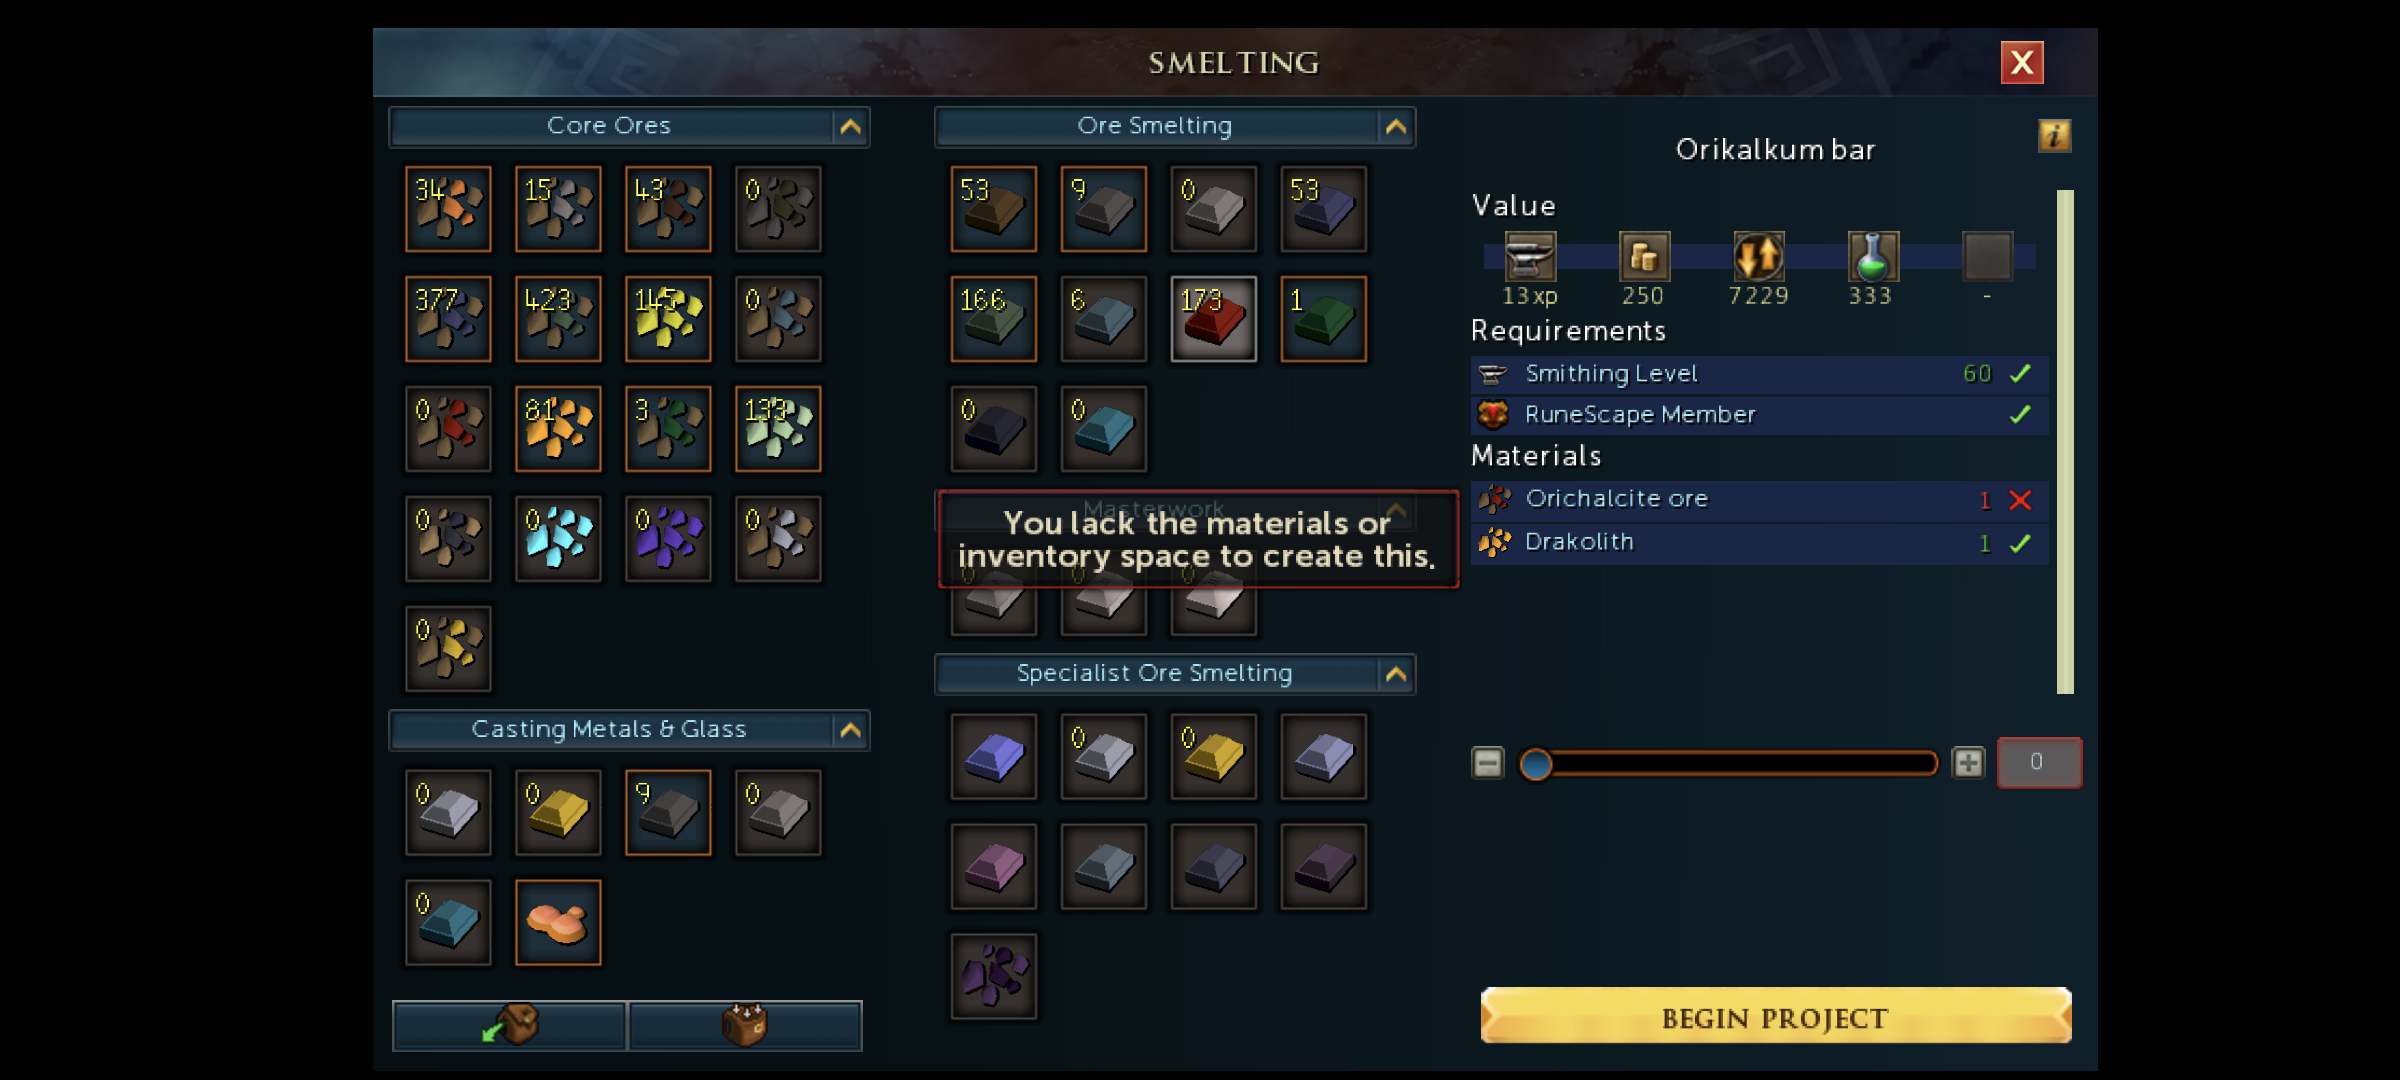

In [32]:
a.matchers = {}

a.addMatcher(
    Beholder_Image_Matcher(
        name="close_btb",
        layer="gray",
        filename="./templates/ui/crafting_dialog_close_button.png",
        convertToGray=True,
    )
)
a.addMatcher(
    Beholder_Image_Matcher(
        name="Button",
        layer="gray",
        filename="./templates/ui/Begin_project.png",
        convertToGray=True,
    )
)
Button_count = 0
while True:
    matches = a.findMatches()
    if len(matches) > 0:
        if "close_btb" in matches:
            Button_count = 0
            sleep(5)
            continue
        else:
            if "Button" in matches:
                if Button_count == 0:
                    center = matches["Button"][0][1]
                    adb(f"shell input tap {center[0]} {center[1]}")
                    Button_count += 1
                    tts("new loop")
                else:
                    print("Cannot continue smelting.")
                    a.layers["image"].show()
                    break
    else:
        adb(f"shell input tap 1150 780")
        sleep(3)
        adb(f"shell input tap 518 1029")
    sleep(3)
tts("Cannot Continue")

# Bolt Featherer


In [ ]:
a.matchers = {}
a.addMatcher(
    Beholder_Image_Matcher(
        name="bolts",
        layer="gray",
        filename="./templates/inventory/addy_bolts.png",
        convertToGray=True,
    )
)
a.addMatcher(
    Beholder_Image_Matcher(
        name="fletch",
        layer="gray",
        filename="./templates/ui/fletch.png",
        convertToGray=True,
    )
)
a.addMatcher(
    Beholder_Image_Matcher(
        name="close_btb",
        layer="gray",
        filename="./templates/ui/crafting_dialog_close_button.png",
        convertToGray=True,
    )
)

in_menu = False
while True:
    matches = a.findMatches()
    if len(matches) > 0:
        if "close_btb" in matches:
            print("Currently Crafting")
            sleep(2)
            continue
        if in_menu:
            if "fletch" in matches:
                center = matches["fletch"][0][1]
                adb(f"shell input tap {center[0]} {center[1]}")
                in_menu = False
        else:
            if "bolts" in matches:
                center = matches["bolts"][0][1]
                adb(f"shell input tap {center[0]} {center[1]}")
                in_menu = True
    else:
        break
    sleep(2)
tts("Cannot Continue")

a.layers["image"].show()

# Mine and store in OreChest/NotePaper/Mining Stamina

In [29]:
a.matchers = {}
a.addMatcher(
    Beholder_Image_Matcher(
        name="paper",
        layer="inventory",
        filename="./templates/inventory/notepaper.png",
    )
)
a.addMatcher(
    Beholder_Image_Matcher(
        name="ore",
        layer="inventory",
        filename="./templates/inventory/ore/rune_inventory.png",
    )
)
a.addMatcher(
    Beholder_Image_Matcher(
        name="orebox", layer="inventory", filename="./templates/inventory/ore/box2.png"
    )
)

s = time.time()
ore_box_full = False

start_mining = 0
previous_ore_count = 0
tts("starting AutoMiner")
while True:
    if time.time() - start_mining >= 20:
        print("reset mining")
        adb(f"shell input tap 1215 830")
        start_mining = time.time()
    matches = a.findMatches()
    if len(matches.keys()) > 0:
        if "ore" in matches:
            if previous_ore_count != matches["ore"][0][2]:
                print(f"{matches['ore'][0][2]} ores in inventory")
                previous_ore_count = matches["ore"][0][2]
            if matches["ore"][0][2] >= 10:
                print(f"Took {time.time() - s} Seconds to mine 10 ore")
                tts("10 c")
                s = time.time()
                if not ore_box_full:
                    if "orebox" in matches:
                        print("oreboxing")
                        center = matches["orebox"][0][1]
                        adb(f"shell input tap {center[0]} {center[1]}")
                        time.sleep(1)
                        matches = a.findMatches()
                        if "ore" in matches.keys():
                            print("I think the ore box is full!")
                            ore_box_full = True
                            tts("o b is full, using paper")
                        else:
                            start_mining = 0
                            continue

                if "ore" in matches:
                    print("papering")
                    center = matches["ore"][0][1]
                    adb(f"shell input tap {center[0]} {center[1]}")
                    time.sleep(0.5)
                    if "paper" in matches:
                        center = matches["paper"][0][1]
                        adb(f"shell input tap {center[0]} {center[1]}")
                        start_mining = 0
                        time.sleep(2)
                    else:
                        print("out of paper")
                        tts("no more paper")
                        break
    if start_mining != 0:
        time.sleep(10)

tts("Cannot Continue")
a.layers["image"].show()
# https://runescape.wiki/w/Necronium_bar

reset mining


KeyboardInterrupt: 

# Scareb gather

In [ ]:
a.matchers = {}
for i in range(0, 5):
    print(i)
    a.addMatcher(
        Beholder_Image_Matcher(
            name="bug",
            layer="gray",
            filename=f"./templates/bug{i}.png",
            convertToGray=True,
            threshhold=0.9,
        )
    )
while True:
    matches = a.findMatches()
    if len(matches) > 0:
        print(matches)
    print(".")
tts("Cannot Continue")

In [ ]:
a.layers

# Other Stuff

In [ ]:
time.time() - s

In [ ]:
447 / 20

In [37]:
tts("Cannot Continue")

In [ ]:
a.layer_modifiers["Horizon"].enabled = True
a.layer_modifiers["Horizon Enemy Finder"].enabled = True

In [ ]:
while True:
    a.readNextImage()
    a.digestImage()

    a.layers["Horizon Enemy Finder"].show()

In [ ]:
a.layer_modifiers["Horizon"].enabled = False
a.layer_modifiers["Horizon Enemy Finder"].enabled = False

In [ ]:
target_color = (143, 4, 13)
tolarance = 75

target_info_cords = (460, 546)
target_info_color = (17, 42, 50)

In [ ]:
a.layers["Horizon Enemy Finder"].show()

In [ ]:
a.layers["Horizon Enemy Finder"].show()

In [ ]:
for item in a.matchers:
    print(item.name, item.data.shape)

In [ ]:
matches = a.findMatches()
print(matches.keys())

In [ ]:
a.layers["gray"].data.shape